
# General breakdown of the processing steps for embedding BPMN files:

## IMPORTANT: 
The current model uses an embedding created by 'paraphrase-multilingual-MiniLM-L12-v2' with an embedding dimension of 384.
Using any other sentence-transformer will result in unexpected behavior, so when using the kerasEmbedder use it toghether with the correct sentence-transformer.
If using it with mu-search, adjust the 'dims' parameter to the appropriate size.

## Motivation:
The goal is to create embeddings for BPMN files that can be used for search, similarity, and clustering tasks.

* The embeddings should be able to capture the semantics of the BPMN files, such that similar BPMN files have similar embeddings.
* The embeddings should be able to capture the structure of the BPMN files, such that BPMN files with similar structures have similar embeddings.
* Make semantic search possible:
* Given a query BPMN file, the system should be able to retrieve similar BPMN files based on the query of the user. User queries can be keywords, key     phrases, or natural language queries. Example: "Geef mij alle BPMN diagrammen over het melden van klachten."

## Design choices:
* Embedding models have a fixed input size, so we need to preprocess the BPMN files so they fit the input size, or we need a way to handle large inputs by splitting them into smaller parts.  
* Embedding models do not take the structure of the BPMN diagrams into account, so we need to find a way to encode the structure of the BPMN diagrams into the embeddings.  
* We want to create a single embedding for the BPMN file that captures both the semantics and structure of the BPMN file.
* Semantics: The most important information in BPMN files is in the nodes and edges, so we need to extract the nodes and edges from the BPMN files. More specifically, we need to extract the labels of the nodes and edges and additional information. This comes down to 'name' and 'documentation' fields of the nodes and edges.  
* To encode the structure of the BPMN diagrams, we can use graph embedding techniques such as Graph Neural Networks (GNNs) or Graph Convolutional Networks (GCNs).  
* As these methods expect a graph as input, we need to convert the BPMN diagrams into a graph representation. A great library for this is NetworkX.  
* To use the information of the nodes and edges, we need to convert them into numerical vectors. This can be done by using pre-trained embeddings or by training our own embeddings (see RoBERTa-model trained on Lokaal Beslist).
* To create a baseline, we can simply average the embeddings of the nodes and edges to create a single embedding for the BPMN file.
* To create a more advanced model, we can use a GNN or GCN using libraries such as Spektral or DGL.


## Search model specifics:
* The search model should be able to handle user queries in the form of keywords, key phrases, or natural language queries.
* The search model should be able to retrieve similar BPMN files based on the query of the user.
* The search model should be able to rank the retrieved BPMN files based on their similarity to the query.
* The search model should be able to handle large amounts of BPMN files and queries efficiently.


## Search model design:
The search model should use the embeddings of the BPMN files and the query to calculate the similarity between the query and the BPMN files.
Embeddings only need to be calculated once for each BPMN file, so they can be precomputed and stored in a database.
With a simple cosine similarity, we can calculate the similarity between the query and the BPMN files. This can be done in Elasticsearch and be easily integrated into mu-search.


## Current approach:
* Convert BPMN files to graph representations using NetworkX.
* Create embeddings for the nodes and edges using pre-trained embeddings.
* Use the embeddings as features for a GNN or GCN model to create a single graph embedding for a BPMN file using Spektral.


## Shortcomings:
Lack of BPMN files to train our own embeddings and validate the model.  
Lack of real user queries to validate the model.  
**Future steps or what should be done next when enough data is available:**
* Start gathering information: Gather BPMN files, user queries, and other relevant data as training can only be done with enough data. Requirements (same as similarity): It's important to have a large enough dataset of BPMN files with enough variety to train the embeddings and validate the model. For example, if all the data is about the same process (handling of disputes), the model will not be able to generalize to other processes. It's hard to quantify how much data is needed, but a few hundred BPMN files should be a good start.
* Train our own text embeddings for the nodes and edges using a model such as RoBERTa trained on BPMN files.
* Validate the current Spektral model using the new data.
* Change the architecture of the GNN or GCN model if needed (possibly add more layers, change the activation functions, etc.).
* Merge the two models: There is a lot of overlap between the two models, so it might be possible to merge them into a single model and use the graph embeddings for both tasks.


## Suggestions:
* Store all search results from mu-search (anonymously) to use as training data, so all types of queries are automatically covered. For example, store each search request to Lokaal Beslist to gain insights into how users typically structure their queries.
* Store the interactions with the search results to gain insights into how users interact with the search results. For example, store the search results from Lokaal Beslist and the interactions. This can be used to train a model to rank the search results based on the interactions of the users.

In [4]:
import os
import json
from tqdm import tqdm
from library.BPMNGraphEmbedder import BPMNGraphEmbedderKeras
from library.BPMNGraph import BPMNGraph


# Start by loading in the BPMN files using the BPMNGraph class and the BPMNGraphEmbedderKeras class, for converting it to a networkx graph and embedding it respectively.
# Then, load in the search dataset and create samples from it. Each sample should contain the query, the query embedding, the BPMN graph, and the label.

def process_bpmn_files(folders):
    """
    Processes BPMN files in the given folders.

    Parameters:
    folders (list of str): The folders to process.

    Returns:
    dict: A dictionary mapping file names to BPMN graphs.
    EmbeddingModel: The sentence embedding model used.
    """
    graphEmbedder = BPMNGraphEmbedderKeras()
    sentence_embedder = graphEmbedder.get_embedding_model()
    all_bpmns = {}

    for folder in folders:
        bpmn_files = [f for f in os.listdir(folder) if f.endswith('.bpmn')]
        for bpmn_file in tqdm(bpmn_files[:100]):
            bpmn_graph = BPMNGraph(os.path.join(folder, bpmn_file))
            graphEmbedder.process_graph(bpmn_graph, logging=False)
            all_bpmns[bpmn_file] = bpmn_graph

    return all_bpmns, sentence_embedder

def create_samples(file_paths, all_bpmns, sentence_embedder):
    """
    Creates samples from the given file paths.

    Parameters:
    file_paths (list of str): The file paths to process.
    all_bpmns (dict): A dictionary mapping file names to BPMN graphs.
    sentence_embedder (EmbeddingModel): The sentence embedding model to use.

    Returns:
    list: A list of samples.
    """
    samples = []

    for file_path in file_paths:
        with open(file_path, "r") as file:
            for line in file:
                data = json.loads(line)
                query = data.get("query")
                bpmn_path = data.get("meta").get("file")
                label = data.get("meta").get("label")
                bpmn_graph = all_bpmns.get(bpmn_path)

                if bpmn_graph is None:
                    print(f"BPMN not found: {bpmn_path}")
                    continue

                query_embedding = sentence_embedder.encode(query)

                samples.append({
                    "query": query,
                    "query_embedding": query_embedding,
                    "bpmn": bpmn_graph,
                    "label": label
                })

    return samples

bpmn_folders = ["data\\bpmn\\"]
search_file_paths = ["datasets\\prodigy_bpmn_search_01_dataset.jsonl",
                     "datasets\\prodigy_bpmn_search_02_dataset.jsonl"]

all_bpmns, sentence_embedder = process_bpmn_files(bpmn_folders)
samples = create_samples(search_file_paths, all_bpmns, sentence_embedder)

print(f"num samples: {len(samples)}")

C:\Users\StefaanVercoutere\AppData\Roaming\Python\Python311\site-packages\keras\src\initializers\initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(
  0%|          | 0/17 [00:00<?, ?it/s]ERROR:root:An error occurred in 'extract_keywords': not enough values to unpack (expected 2, got 0). Failed to extract keywords from text: no. Likely due to text length being too short.
ERROR:root:An error occurred in 'extract_keywords': not enough values to unpack (expected 2, got 0). Failed to extract keywords from text: always. Likely due to text length being too short.
 82%|████████▏ | 14/17 [02:24<00:33, 11.26s/it]ERROR:root:An error occurred in 'extract_keywords': not enough values to unpack (expected 2, got 0). Failed t

num samples: 1805


# baseline performance by averaging graph embeddings and comparing cosine similarity of the query embedding

In [10]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# testing the performance of the cosine similarity using the node embeddings of the Custom Spektral model and average pooling
accuracy = []

for sample in samples:
    query = sample.get("query")
    query_embedding = np.array(sample.get("query_embedding")).reshape(1, -1)
    bpmn_graph = np.array(sample.get("bpmn").get_graph()["embedding"]).reshape(1, -1)
    label = sample.get("label")

    similarity = cosine_similarity(query_embedding, bpmn_graph)[0][0]
    found = similarity > 0.4  # You can adjust this threshold as needed

    accuracy.append(int(found == label))

print(f"Accuracy: {np.mean(accuracy)}")

Accuracy: 0.8132963988919668


In [51]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
# testing the performance of the cosine similarity using the node embeddings of the base sentence transformer and average pooling

accuracy = []

for sample in samples:
    query = sample.get("query")
    query_embedding = np.array(sample.get("query_embedding")).reshape(1, -1)
    bpmn_graph = np.array(sample.get("bpmn").get_graph()["embedding_averaging"]).reshape(1, -1)
    label = sample.get("label")

    similarity = cosine_similarity(query_embedding, bpmn_graph)[0][0]
    found = similarity > 0.4  # You can adjust this threshold as needed

    accuracy.append(int(found == label))

print(f"Accuracy: {np.mean(accuracy)}")

Accuracy: 0.7058171745152355


# Creating a Spektral dataset for the training samples

In [52]:
from spektral.data import Graph, Dataset, Loader, BatchLoader
from spektral.data.utils import get_spec, collate_labels_batch, sp_matrices_to_sp_tensors, to_batch

import tensorflow as tf
import networkx as nx
import numpy as np

class BpmmSpektralLoader(Loader):
    def __init__(self, dataset, mask=False, batch_size=1, epochs=None, shuffle=True, node_level=False):
        self.mask = mask
        self.node_level = node_level
        self.signature = dataset.signature
        super().__init__(dataset, batch_size=batch_size, epochs=epochs, shuffle=shuffle)

    def numpy(self, graph):
        # Return tuple of non-None elements
        return tuple(ret for ret in [graph.x, graph.a, graph.z, graph.y] if ret is not None)

    def collate(self, batch):
        # Prepare output and keys
        output = [list(elem) for elem in zip(*[self.numpy(g) for g in batch])]
        keys = [k + "_list" for k in self.dataset.signature.keys()]
        packed = dict(zip(keys, output))

        # Process labels
        y = packed.pop("y_list", None)
        if y is not None:
            y = collate_labels_batch(y, node_level=self.node_level)

        # Process embeddings
        query_embeddings =  packed.pop("z_list", None)
        output = to_batch(**packed, mask=self.mask)   

        # Convert sparse matrices to tensors
        X, A = output
        output = sp_matrices_to_sp_tensors((X, A, np.array(query_embeddings)))
        
        # Return output
        if len(output) == 1:
            output = output[0]
        if y is None:
            return output
        else:
            return output, y

class BPMNGraphProcessor:
 
    def get_node_features(self, bpmn_graph):
        # Get node features
        x = [node.get("embedding", np.zeros(384)).reshape(-1) for _, node in bpmn_graph.network.nodes(data=True)]
        return np.stack(x)

    def get_adjacency_matrix(self, bpmn_graph):
        # Get adjacency matrix
        return nx.adjacency_matrix(bpmn_graph.network).tocoo()
 
class BPMNGraphDataset(Dataset):
    def __init__(self, samples, **kwargs):
        self.samples = samples
        self.embedding_dims = samples[0]["query_embedding"].shape[0]
        self.processor = BPMNGraphProcessor()
        super().__init__(**kwargs)

    def read(self):
        graphs = []
        for sample in self.samples:
            bpmn_graph = sample["bpmn"]
            if len(bpmn_graph.get_nodes()) == 0 or len(bpmn_graph.get_edges()) == 0:
                continue

            # Add self loop
            for node in bpmn_graph.network.nodes():
                bpmn_graph.network.add_edge(node, node)

            # Get adjacency matrix
            a = self.processor.get_adjacency_matrix(bpmn_graph)

            # Get node features
            x = self.processor.get_node_features(bpmn_graph)

            # Get query embedding
            z = sample["query_embedding"]

            # Get class labels (convert boolean to int)
            if "label" in sample:
                y = int(sample["label"])

                # Create Graph object
                graphs.append(Graph(x=x, a=a, z=z, y=y))
            else:
                graphs.append(Graph(x=x, a=a, z=z))

        return graphs
    @property
    def signature(self):
        """
        This property computes the signature of the dataset, which can be
        passed to `spektral.data.utils.to_tf_signature(signature)` to compute
        the TensorFlow signature. You can safely ignore this property unless
        you are creating a custom `Loader`.

        A signature consist of the TensorFlow TypeSpec, shape, and dtype of
        all characteristic matrices of the graphs in the Dataset. This is
        returned as a dictionary of dictionaries, with keys `x`, `a`, `e`, and
        `y` for the four main data matrices.

        Each sub-dictionary will have keys `spec`, `shape` and `dtype`.
        """
        if len(self.graphs) == 0:
            return None
        signature = {}
        graph = self.graphs[0]  # This is always non-empty
        if graph.x is not None:
            signature["x"] = dict()
            signature["x"]["spec"] = get_spec(graph.x)
            signature["x"]["shape"] = (None, self.n_node_features)
            signature["x"]["dtype"] = tf.as_dtype(graph.x.dtype)
        if graph.a is not None:
            signature["a"] = dict()
            signature["a"]["spec"] = get_spec(graph.a)
            signature["a"]["shape"] = (None, None)
            signature["a"]["dtype"] = tf.as_dtype(graph.a.dtype)
        if graph.z is not None:
            signature["z"] = dict()
            signature["z"]["spec"] = get_spec(graph.z)
            signature["z"]["shape"] = (self.embedding_dims,)
            signature["z"]["dtype"] = tf.as_dtype(np.array(graph.z).dtype)
        if graph.y is not None:
            signature["y"] = dict()
            signature["y"]["spec"] = get_spec(graph.y)
            signature["y"]["shape"] = (self.n_labels,)
            signature["y"]["dtype"] = tf.as_dtype(np.array(graph.y).dtype)
        return signature
    
dataset = BPMNGraphDataset(samples)

# Parameters
F = dataset.n_node_features  # Dimension of node features
S = dataset.n_edge_features  # Dimension of edge features
n_out = dataset.n_labels  # Dimension of the target

# Train/test split
idxs = np.random.permutation(len(dataset))
split = int(0.9 * len(dataset))
idx_tr, idx_te = np.split(idxs, [split])
dataset_tr, dataset_te = dataset[idx_tr], dataset[idx_te]

# Design the model using the Spektral library and keras

In [68]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Input, Dot
from spektral.layers import GCNConv, GlobalAvgPool, GlobalAttentionPool, GATConv
from tensorflow.keras.metrics import Precision, Recall, AUC

def create_models(n_features, embedding_dims):
    # Define the inputs
    X_in = Input(shape=(None, n_features), name='Node_features')
    A_in = Input((None, ), sparse=True, name='Adjacency_matrix')
    Z_in = Input((embedding_dims, ), name='Query_embedding')

    # Define the model architecture
    graph_conv = GCNConv(embedding_dims, activation='relu', name='graph_conv')([X_in, A_in])
    dropout = Dropout(0.2, name='dropout')(graph_conv)
    graph_conv_2 = GCNConv(embedding_dims, activation='relu', name='graph_conv_2')([dropout, A_in])
    dropout_2 = Dropout(0.2, name='dropout_2')(graph_conv_2)
    graph_conv_3 = GCNConv(embedding_dims, activation='relu', name='graph_conv_3')([dropout_2, A_in])
    graph_embedding = GlobalAttentionPool(embedding_dims,name='global_pool')(graph_conv_3)

    # Perform dot product between the graph embedding and the query embedding
    dot_product = Dot(axes=1, normalize=True, name='dot_product')([graph_embedding, Z_in])

    
    # Create the model
    embedding_model = Model(inputs=[X_in, A_in], outputs=graph_embedding, name='embedding_model')
    prediction_model = Model(inputs=[X_in, A_in, Z_in], outputs=dot_product, name='my_model')

    prediction_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', Precision(), Recall(), AUC()])
    embedding_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', Precision(), Recall(), AUC()])


    return prediction_model, embedding_model

# Create the model
model, embedding_model = create_models(n_features=dataset.n_node_features, embedding_dims=dataset.embedding_dims)
model.summary()

Model: "my_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Node_features (InputLayer)  [(None, None, 384)]          0         []                            
                                                                                                  
 Adjacency_matrix (InputLay  [(None, None)]               0         []                            
 er)                                                                                              
                                                                                                  
 graph_conv (GCNConv)        (None, None, 384)            147840    ['Node_features[0][0]',       
                                                                     'Adjacency_matrix[0][0]']    
                                                                                           

X shape: (32, 641, 384), A shape: (32, 641, 641), Z shape: (32, 384), y shape: (32,)
Epoch 1/20
51/51 [==============================] - 33s 629ms/step - loss: 0.6969 - accuracy: 0.6509 - precision_19: 0.7376 - recall_19: 0.4479 - auc_19: 0.7273
Epoch 2/20
51/51 [==============================] - 37s 734ms/step - loss: 0.5128 - accuracy: 0.7611 - precision_19: 0.8711 - recall_19: 0.6023 - auc_19: 0.8844
Epoch 3/20
51/51 [==============================] - 39s 755ms/step - loss: 0.4869 - accuracy: 0.7845 - precision_19: 0.8942 - recall_19: 0.6361 - auc_19: 0.9017
Epoch 4/20
51/51 [==============================] - 36s 697ms/step - loss: 0.4734 - accuracy: 0.7894 - precision_19: 0.8957 - recall_19: 0.6462 - auc_19: 0.9125
Epoch 5/20
51/51 [==============================] - 38s 748ms/step - loss: 0.4649 - accuracy: 0.7974 - precision_19: 0.9091 - recall_19: 0.6524 - auc_19: 0.9179
Epoch 6/20
51/51 [==============================] - 38s 748ms/step - loss: 0.4590 - accuracy: 0.8048 - precisi

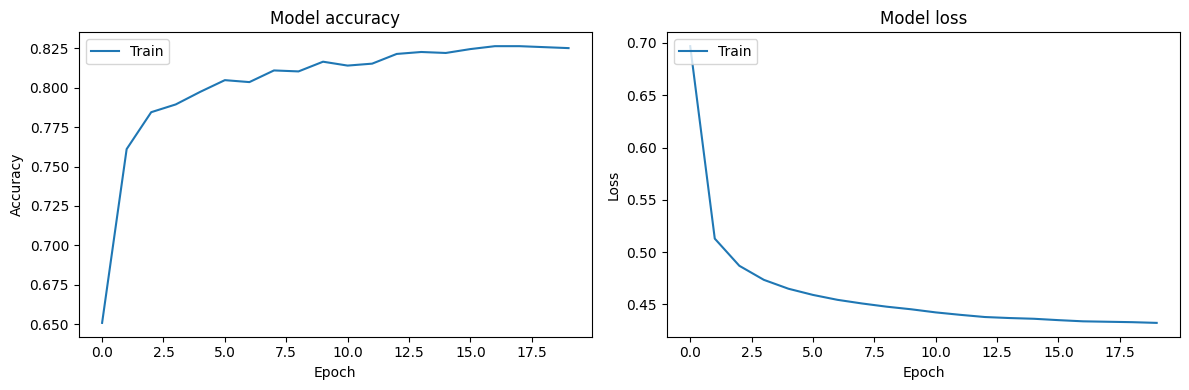

In [69]:
import matplotlib.pyplot as plt

def train_model(model, dataset, dataset_val, batch_size=32, epochs=10):
    """
    Trains the model on the given dataset.

    Parameters:
    model (Model): The model to train.
    dataset (Dataset): The dataset to train the model on.
    batch_size (int): The batch size to use for training.
    epochs (int): The number of epochs to train the model for.

    Returns:
    History: A History object. Its History.history attribute is a record of training loss values and metrics values at successive epochs.
    """
    try:
        # Create a loader
        loader = BpmmSpektralLoader(dataset, batch_size=batch_size, shuffle=False)

        # Log the shapes of the inputs and targets
        batch = next(loader.load())
        inputs, y = batch
        X, A, Z = inputs
        print(f"X shape: {X.shape}, A shape: {A.shape}, Z shape: {Z.shape}, y shape: {y.shape}")

        # Train the model
        history = model.fit(loader.load(),
                            steps_per_epoch=loader.steps_per_epoch,
                            epochs=epochs)

        return history
    except Exception as e:
        print(f"An error occurred: {e}")

    return None

def evaluate_model(model, dataset, batch_size=32):
    """
    Evaluates the model on the given dataset.

    Parameters:
    model (Model): The model to evaluate.
    dataset (Dataset): The dataset to evaluate the model on.
    batch_size (int): The batch size to use for evaluation.

    Returns:
    float: The loss value & accuracy value of the model.
    """
    try:
        # Create a loader
        loader = BpmmSpektralLoader(dataset, batch_size=batch_size, shuffle=False)

        # Evaluate the model
        metrics = model.evaluate(loader.load(), steps=loader.steps_per_epoch)

        return metrics
    
    except Exception as e:
        print(f"An error occurred: {e}")

    return None, None

def plot_history(history):
    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train'], loc='upper left')

    plt.tight_layout()
    plt.show()


# Train the model
history = train_model(model, dataset_tr, dataset_te, epochs = 20)
metrics = evaluate_model(model, dataset_te)
#print(f"Eval loss: {eval_loss}, Eval accuracy: {eval_accuracy}")

# Plot the training history
plot_history(history)

In [77]:
metrics= evaluate_model(model, dataset_tr)
print(f"Eval loss: {metrics[0]}, Eval accuracy: {metrics[1]}")

51/51 [==============================] - 16s 309ms/step - loss: 0.4219 - accuracy: 0.8368 - precision_19: 0.9508 - recall_19: 0.7039 - auc_19: 0.9462
Eval loss: 0.42194318771362305, Eval accuracy: 0.8368226885795593


# Save the model for later use in the BPMN search application

In [42]:
embedding_model.save('bpmn_search_embedding_model.keras')
model.save('bpmn_search_full_model.keras')




# Loading the model back into memory and testing inference

In [86]:
from tensorflow.keras.models import load_model
from tensorflow.keras.initializers import GlorotUniform, Zeros
from spektral.layers import GCNConv, GlobalAvgPool, GlobalAttentionPool

# Define the custom objects
custom_objects = {
    'GCNConv': GCNConv,
    'GlobalAvgPool': GlobalAvgPool,
    'GlobalAttentionPool': GlobalAttentionPool,
    'GlorotUniform': GlorotUniform,
    'Zeros': Zeros
}

# Load the models
loaded_embedding_model = load_model('models/bpmn_search_0.1.0/bpmn_search_embedding_model.keras', custom_objects=custom_objects)
loaded_full_model = load_model('models/bpmn_search_0.1.0/bpmn_search_full_model.keras', custom_objects=custom_objects)

C:\Users\StefaanVercoutere\AppData\Roaming\Python\Python311\site-packages\keras\src\initializers\initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


In [21]:
list(all_bpmns.keys())

['dispatch.bpmn',
 'hoofdprocesProcesMelding.bpmn',
 'Jeugd-Fuifkwaliteitslabel-aanvraag-Poperinge_v0.1.bpmn',
 'Jeugd-Kadervormingsubsidieaanvraag-Poperinge_v0.1.bpmn',
 'Jeugd-Project-subsidieaanvraag-Poperinge_v0.1.bpmn',
 'Jeugd-subsidieaanvraag-Poperinge_v0.1.bpmn',
 'Jeugd-verenigingen-met-specifieke-doelgroep-subsidie-Poperinge_v0.1.bpmn',
 'Klachten-Heuvelland.bpmn',
 'Klachten-Kortemark.bpmn',
 'klachtenbehandeling.bpmn',
 'Meldingen-Heuvelland.bpmn',
 'Meldingen-Kortemark.bpmn',
 'rijbewijs.bpmn',
 'Sport-Subsidieaanvraag-De-Panne_v0.1.bpmn',
 'Sport-Subsidieaanvraag-De-Panne_v0.1_translated_English.bpmn',
 'Sport-Subsidieaanvraag-De-Panne_v0.1_translated_French.bpmn',
 'Sport-Subsidieaanvraag-GrootstGemeneDeler_v0.3.bpmn']

In [71]:
import numpy as np

def query_bpmn(query, bpmn_graph, sentence_embedder, model):
    """
    Predicts the class of a BPMN graph based on a query.

    Parameters:
    query (str): The query to match with the BPMN graph.
    bpmn_graph (dict): The BPMN graph to classify.
    sentence_embedder (SentenceTransformer): The sentence transformer to use for embedding the query.
    model (Model): The model to use for prediction.

    Returns:
    np.array: The predicted class of the BPMN graph.
    """
    try:
        # Embed the query
        query_embedding = sentence_embedder.encode(query)
        query_embedding = query_embedding
        
        # Create processor
        bpmn_processor = BPMNGraphProcessor()

        x = bpmn_processor.get_node_features(bpmn_graph)
        x = np.expand_dims(x, axis=0)  # Expands the dimensions to (1, N, F)

        a = bpmn_processor.get_adjacency_matrix(bpmn_graph)
        a = np.expand_dims(a.toarray(), axis=0)  # Expands the dimensions to (1, N, N)
        
        z = np.expand_dims(query_embedding, axis=0)  # Expands the dimensions to (1, F)

        print(f"X shape: {x.shape}, A shape: {a.shape}, Z shape: {z.shape}")
        # Predict the class
        prediction = model.predict([x, a, z])
        return prediction
    
    except Exception as e:
        print(f"An error occurred: {e}")
        return None
    
# Get a random BPMN graph
bpmn_graph = all_bpmns['Sport-Subsidieaanvraag-De-Panne_v0.1.bpmn']
query = "geef me een bpmn diagram voor het aanvragen van een sportsubsidie"

# Predict the class
prediction = query_bpmn(query, bpmn_graph, sentence_embedder, model)
print(f"Prediction: {prediction}")

X shape: (1, 36, 384), A shape: (1, 36, 36), Z shape: (1, 384)
1/1 [==============================] - 0s 123ms/step
Prediction: [[0.6471058]]


In [88]:

import os
import numpy as np
from  spektral.data import Graph 

def generate_bpmn_embeddings(bpmn_graphs, embedding_model):
    """
    Generates embeddings for each BPMN graph using the provided embedding model.

    Parameters:
    bpmn_graphs (dict of BPMNGraphs): A dictionary mapping file paths to BPMN graphs.
    embedding_model (Model): The Keras model to use for generating the embeddings.

    Returns:
    dict: A dictionary mapping file paths to their corresponding embeddings.
    """
    # Initialize the dictionary to store the embeddings
    embeddings = {}

    # Iterate over all the BPMN graphs
    for file, bpmn_graph in bpmn_graphs.items():
        # Generate the embedding for the current BPMN graph
        embedding = generate_bpmn_embedding(bpmn_graph, embedding_model)

        # If an embedding was successfully generated, store it
        if embedding is not None:
            embeddings[file] = embedding

    return embeddings

def generate_bpmn_embedding(bpmn_graph, embedding_model):
    """
    Generates an embedding for a single BPMN graph using the provided embedding model.

    Parameters:
    bpmn_graph (BPMNGraph): The BPMN graph.
    embedding_model (Model): The Keras model to use for generating the embedding.

    Returns:
    np.array: The embedding of the BPMN graph.
    """
    bpmn_processor = BPMNGraphProcessor()

    try:
        # Convert the BPMN graph into a graph
        x = bpmn_processor.get_node_features(bpmn_graph)

        for n,f in enumerate(x):
            print(f"Node {n}: {f[:5]}")

        x = np.expand_dims(x, axis=0)  # Expands the dimensions to (1, N, F)
            
        a = bpmn_processor.get_adjacency_matrix(bpmn_graph)
        a = np.expand_dims(a.toarray(), axis=0)  # Expands the dimensions to (1, N, N)

        print(a)
        # Generate the embedding
        embedding = embedding_model.predict([x, a], verbose=0)

        return embedding[0]
        
    except Exception as e:
        print(f"An error occurred during the processing of the BPMN graph: {e}")
        return None

def query_bpmn_embeddings(query, embeddings, sentence_embedder):
    """
    Queries the BPMN embeddings for the most similar BPMN files to the given query.

    Parameters:
    query (str): The query to match with the BPMN embeddings.
    embeddings (dict): A dictionary mapping file paths to their corresponding embeddings.
    sentence_embedder (SentenceTransformer): The sentence transformer to use for embedding the query.

    Returns:
    list: A list of tuples containing the file paths and their corresponding similarity scores.
    """
    try:
        # Embed the query
        query_embedding = sentence_embedder.encode(query)

        # Calculate the similarity scores
        scores = {}
        for file, embedding in embeddings.items():
            # Calculate the cosine similarity
            similarity = np.dot(embedding, query_embedding.T) / (np.linalg.norm(embedding) * np.linalg.norm(query_embedding))
            # Calculate the cosine similarity
            similarity = np.dot(embedding, query_embedding.T) / (np.linalg.norm(embedding) * np.linalg.norm(query_embedding))
            if np.isscalar(similarity):
                scores[file] = similarity
            else:
                scores[file] = similarity[0][0]

        # Sort the scores
        sorted_scores = sorted(scores.items(), key=lambda x: x[1], reverse=True)
        return sorted_scores
    
    except Exception as e:
        print(f"An error occurred: {e}")
        return None

# Processing all BPMN files and storing the embeddings

embeddings = generate_bpmn_embeddings(all_bpmns, embedding_model)

# testing of the embeddings by creating a query and checking the similarity with the embeddings, returns the sorted list of the similarity scores and the corresponding file names
 
# Query the BPMN embeddings
query = "geef me een bpmn diagram voor het aanvragen van een sportsubsidie"
sorted_scores = query_bpmn_embeddings(query, embeddings, sentence_embedder)

sorted_scores[:10]

Node 0: [0. 0. 0. 0. 0.]
Node 1: [ 0.11084785 -0.20125678 -0.11646175  0.09873834  0.29635423]
Node 2: [0.10750081 0.02924155 0.33194169 0.03794462 0.24711959]
Node 3: [ 0.46368176 -0.08620588 -0.20258562 -0.01018196  0.02533997]
Node 4: [ 0.11483502  0.15222724  0.18590665  0.03046663 -0.01982365]
Node 5: [0. 0. 0. 0. 0.]
Node 6: [ 0.23805699  0.01020636 -0.37339929 -0.16352265  0.11018137]
Node 7: [ 0.05870692  0.2123425  -0.21806161 -0.05845609  0.1740801 ]
Node 8: [-0.36818019  0.09185436 -0.09720701 -0.01493474  0.26400062]
Node 9: [ 0.14889477 -0.01188441 -0.0031891  -0.17205842  0.16890572]
Node 10: [0. 0. 0. 0. 0.]
Node 11: [ 0.00251071 -0.098156    0.0596109   0.0604212   0.35650766]
Node 12: [0. 0. 0. 0. 0.]
Node 13: [ 0.05945975 -0.04023983 -0.24303578 -0.33218065  0.24368003]
Node 14: [ 0.07836308 -0.25003943  0.64728445  0.01878345 -0.27628574]
Node 15: [-0.09413631 -0.53121275  0.08685507 -0.15573958 -0.29351991]
Node 16: [ 0.38926116 -0.33328485  0.17181401 -0.08531771 -

[('Sport-Subsidieaanvraag-De-Panne_v0.1_translated_French.bpmn', 0.6675167),
 ('Sport-Subsidieaanvraag-De-Panne_v0.1_translated_English.bpmn', 0.6594982),
 ('Sport-Subsidieaanvraag-De-Panne_v0.1.bpmn', 0.64710605),
 ('Jeugd-Project-subsidieaanvraag-Poperinge_v0.1.bpmn', 0.53689176),
 ('Sport-Subsidieaanvraag-GrootstGemeneDeler_v0.3.bpmn', 0.52841055),
 ('Jeugd-Kadervormingsubsidieaanvraag-Poperinge_v0.1.bpmn', 0.5056721),
 ('Jeugd-verenigingen-met-specifieke-doelgroep-subsidie-Poperinge_v0.1.bpmn',
  0.50058585),
 ('Jeugd-subsidieaanvraag-Poperinge_v0.1.bpmn', 0.42337283),
 ('Jeugd-Fuifkwaliteitslabel-aanvraag-Poperinge_v0.1.bpmn', 0.31522602),
 ('dispatch.bpmn', 0.16686864)]

In [89]:
# Get a random BPMN graph
bpmn_graph = all_bpmns['Sport-Subsidieaanvraag-De-Panne_v0.1.bpmn']
query = "geef me een bpmn diagram voor het aanvragen van een sportsubsidie"

generate_bpmn_embedding(bpmn_graph, loaded_embedding_model)[:10]

Node 0: [0. 0. 0. 0. 0.]
Node 1: [ 0.08223188 -0.30496746 -0.46314657  0.07147508 -0.16230837]
Node 2: [ 0.13948983  0.16989234 -0.10242781 -0.03737248 -0.20744142]
Node 3: [ 0.13420346  0.11925427  0.15771531 -0.0024663  -0.05436249]
Node 4: [ 0.19825216 -0.02402821 -0.04898828 -0.11378941 -0.11310809]
Node 5: [0. 0. 0. 0. 0.]
Node 6: [-0.19834189 -0.09045885 -0.12976845 -0.23772067  0.10081282]
Node 7: [ 0.14510804  0.07042088 -0.2062185  -0.16693847 -0.04890335]
Node 8: [ 0.31136641  0.00202829 -0.11402494 -0.169287   -0.07081637]
Node 9: [ 0.21702342 -0.01765321 -0.18924302  0.15194611 -0.15694191]
Node 10: [-0.01390739  0.49805167  0.05168093  0.09638491 -0.11921238]
Node 11: [ 0.03424754 -0.07957984 -0.0644064  -0.07398027  0.30360222]
Node 12: [-0.13947602  0.03754495 -0.12441344  0.07275176  0.17267513]
Node 13: [ 0.13420346  0.11925427  0.15771531 -0.0024663  -0.05436249]
Node 14: [ 0.13420346  0.11925427  0.15771531 -0.0024663  -0.05436249]
Node 15: [ 0.22250374 -0.1011555   

array([ 13.453316 ,   5.476597 ,  -2.7823763, -74.12457  ,   3.4246166,
       138.6809   ,   2.0665102,  69.78467  ,  -4.1333127,  58.19568  ],
      dtype=float32)